In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convnwb.paths import Paths
from convnwb.io import get_files, load_jsons_to_df, load_matfile
from scipy.stats import binom_test, chi2_contingency

from spiketools.plts.data import plot_hist
from spiketools.plts.utils import make_axes
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [3]:
import sys
sys.path.append('../scripts')
from settings import RUN, PATHS, UNITS,METHODS, SURROGATES

In [4]:
results_folder = PATHS['RESULTS'] / 'units_place'
reports_folder = PATHS['REPORTS'] / 'units_place'


In [5]:
# Get the list of files
res_files = get_files(results_folder, select='session')

In [6]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [7]:
# Check the columns
all_results.columns

Index(['uid', 'session_id', 'subject_id', 'n_spikes', 'firing_rate', 'channel',
       'place_info', 'place_anova', 'place_anova_surr_p_val',
       'place_anova_surr_z_score', 'place_info_surr_p_val',
       'place_info_surr_z_score'],
      dtype='object')

In [8]:
# Check similarity of low firing rate & low presence ratio
low_frs = (all_results['firing_rate'] < 0.1).values
print('# neurons fr < 0.1: \t', sum(all_results.firing_rate < 0.1))
# Add a marker for firing rate threshold in the TH experiment
all_results['keep_sh'] = (all_results['firing_rate'] > 0.1).values


# neurons fr < 0.1: 	 7


## Dropped Neurons 

In [9]:
# Extract dropped neurons
dropped = all_results[~all_results['keep_sh']]

In [10]:
# Check number of dropped neurons
n_dropped = len(dropped)
print('# of dropped units: \t{}'.format(n_dropped))

# of dropped units: 	7


In [11]:
# Sub-select main results file to keep neurons
all_results = all_results[all_results['keep_sh']]

## Check Results 

In [12]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))

Total number of cells: 268


In [24]:
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'    # 'two-sided', 'greater', 'less'

In [25]:
# Collect numbers of significant cells
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values
#     print(all_results[f'{analysis}_surr_p_val'])
    #results[analysis] = sum(all_results['is_' + analysis])

In [26]:
for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])

In [27]:
# Compute significance of the counts of detected neurons
stats = {}
for analysis in analyses:
    stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_87521/2198180662.py:4: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [28]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

total cells: 268

# place_anova cells:     		 17  ( 6.34%) 		 0.1893
# place_info cells:     		 17  ( 6.34%) 		 0.1893


## Group Level Analysis 

In [29]:
df_cleaned = all_results.dropna()
SI = df_cleaned['place_info']
F = df_cleaned['place_anova']

si_pval =  df_cleaned['place_info_surr_p_val']
anova_pval =  df_cleaned['place_anova_surr_p_val']

In [30]:
SI = all_results['place_info']
F = all_results['place_anova']

si_pval =  all_results['place_info_surr_p_val']
anova_pval =  all_results['place_anova_surr_p_val']

In [31]:
len(F[anova_pval < 0.05])

17

## Significant for Spike Information 

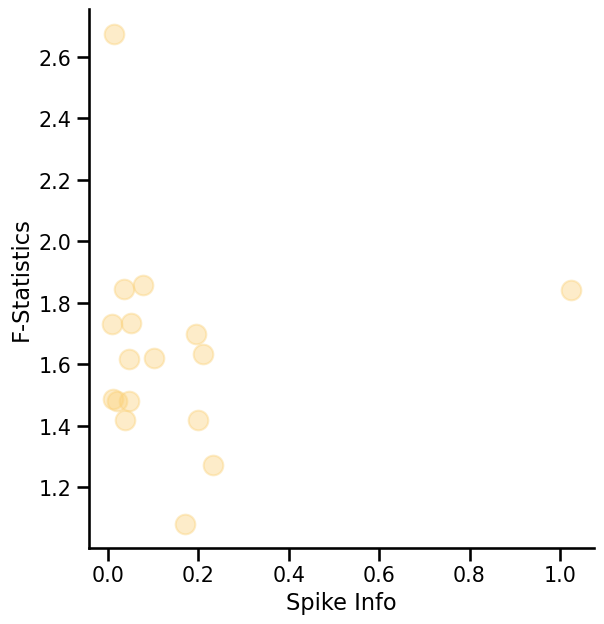

In [32]:
## Forward
plt.rcParams.update({'font.size': 20})
grid = make_grid(1, 2, wspace=.3, hspace=1, figsize=(15, 7),
                 width_ratios=[1,1])
ax = get_grid_subplot(grid, 0, 0)
#ax.scatter(SI ,F,marker='o',color = 'grey',alpha = .4, s=200)
ax.scatter(SI[anova_pval < alpha_level],F[anova_pval < alpha_level] ,marker='o',color = '#FBD178',alpha = .4, s=200)
#ax.scatter(SI[si_pval < 0.05],F[si_pval < 0.05] ,marker='o',color = '#FBD178',alpha = .4, s=100)
ax.set_ylabel('F-Statistics')
ax.set_xlabel('Spike Info')
drop_spines(['top','right'], get_grid_subplot(grid, 0, 0))


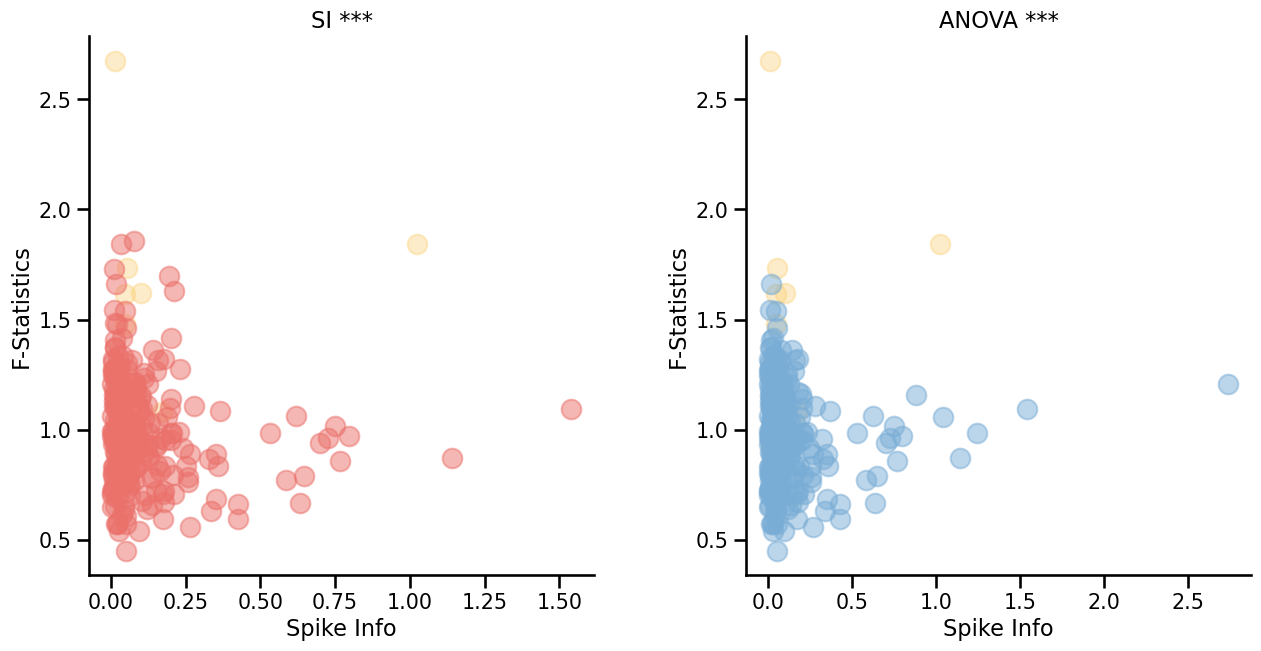

In [33]:
## Forward
plt.rcParams.update({'font.size': 20})
grid = make_grid(1, 2, wspace=.3, hspace=1, figsize=(15, 7),
                 width_ratios=[1,1])
ax = get_grid_subplot(grid, 0, 0)
ax.scatter(SI[(anova_pval < 0.05) & (si_pval < 0.05)],F[(anova_pval < 0.05) & (si_pval < 0.05)],marker='o',color = '#FBD178',alpha = .4, s=200)
#ax.scatter(f_si[(ff_pval >= 0.001) & (fsi_pval < 0.001)], ff_val[(ff_pval >= 0.001) & (fsi_pval < 0.001)],marker='o',color = '#EB716B',alpha = .5, s=200)
ax.scatter(SI[si_pval >= 0.05], F[si_pval >= 0.05],marker='o',color = '#EB716B',alpha = .5, s=200)
ax.set_title('SI ***')
ax.set_ylabel('F-Statistics')
ax.set_xlabel('Spike Info')
drop_spines(['top','right'], get_grid_subplot(grid, 0, 0))

ax = get_grid_subplot(grid, 0, 1)
ax.scatter(SI[(anova_pval < 0.05) & (si_pval < 0.05)],F[(anova_pval < 0.05) & (si_pval < 0.05)],marker='o',color = '#FBD178',alpha = .4, s=200)
#ax.scatter(f_si[(ff_pval < 0.001) & (fsi_pval >= 0.001)], ff_val[(ff_pval < 0.001) & (fsi_pval >= 0.001)],marker='o',color = '#79ADD6',alpha =.5, s=200)
ax.scatter(SI[anova_pval >= 0.05], F[anova_pval >= 0.05],marker='o',color = '#79ADD6',alpha = .5, s=200)
ax.set_title('ANOVA ***')
ax.set_ylabel('F-Statistics')
ax.set_xlabel('Spike Info')
drop_spines(['top','right'], get_grid_subplot(grid, 0, 1))

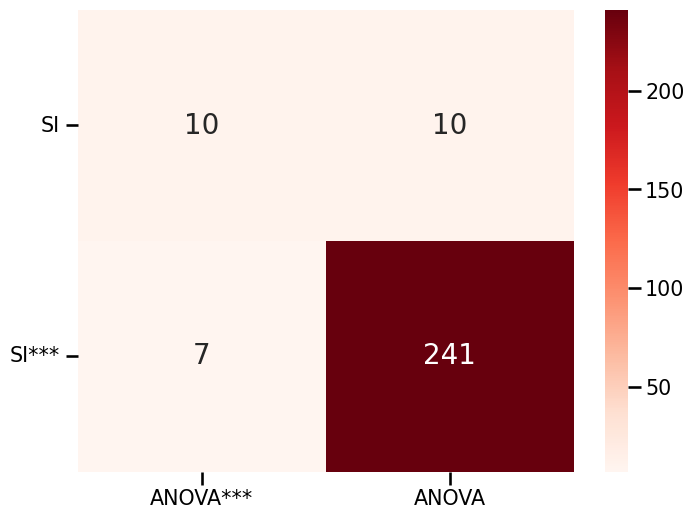

Phi correlation coefficient: 0.37


In [34]:
significant_spike_info = (si_pval < alpha_level)
significant_anova = (anova_pval < alpha_level)

# True positive: Significant in both
tp = np.sum(significant_spike_info & significant_anova)

# False positive: Significant in Spike Info, not in ANOVA
fp = np.sum(significant_spike_info & ~significant_anova)

# False negative: Not significant in Spike Info, significant in ANOVA
fn = np.sum(~significant_spike_info & significant_anova)

# True negative: Not significant in both
tn = np.sum(~significant_spike_info & ~significant_anova)

# Creating a 2x2 matrix
data = np.array([
    [fn, fp],
    [tp, tn]
])
# Creating a DataFrame for the heatmap
forward_df = pd.DataFrame(data, index=['SI', 'SI***'],
                  columns=['ANOVA***', 'ANOVA'])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(forward_df, annot=True, fmt='d', cmap='Reds')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=360, ha='center')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=360)
plt.show()

def phi_coefficient(a, b, c, d):
    numerator = (a * d) - (b * c)
    denominator = np.sqrt((a + b) * (a + c) * (b + d) * (c + d))
    phi = numerator / denominator
    return phi

phi = phi_coefficient(tp, fp, fn, tn)
print(f'Phi correlation coefficient: {phi:.2f}')